In [1]:
# fecthing and saving data

import os
import urllib.request

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/"
ECHOCARDIOGRAM_URL = DOWNLOAD_ROOT + "machine-learning-databases/echocardiogram/echocardiogram.data"
cwd = os.getcwd()
ECHOCARDIOGRAM_PATH = os.path.join(cwd,"datasets","echocardiogram")

def fetch_echocardiogram_data(echocardiogram_url=ECHOCARDIOGRAM_URL, echocardiogram_path=ECHOCARDIOGRAM_PATH):
    echocardiogram_data_path=os.path.join(echocardiogram_path,"echocardiogram.data")
    os.makedirs(echocardiogram_path, exist_ok=True)
    urllib.request.urlretrieve(echocardiogram_url,echocardiogram_data_path)

fetch_echocardiogram_data()

In [2]:
# loading data

import pandas as pd 

pd.set_option("display.max_rows", None)

def load_echocardiogram_data(echocardiogram_path=ECHOCARDIOGRAM_PATH):
        echocardiogram_data_path=os.path.join(echocardiogram_path,"echocardiogram.data")
        return pd.read_csv(echocardiogram_data_path,names=["survival","still-alive","age-at-heart-attack","pericardial-effusion","fractional-shortening","epss","lvdd","wall-motion-score","wall-motion-index","mult","name","group","alive-at-1"], header=None)
    
echocardiogram_data=load_echocardiogram_data()

In [3]:
# prepare data

# replace '?' with None to indicate missing values

echocardiogram_data.replace({'?': None},inplace =True)

# drop instances with missing survival and still-alive attributes

echocardiogram_data.dropna(subset=["survival","still-alive"],inplace=True)

# drop instances with survival less than 12 months and still-alive equal to 1

echocardiogram_data["survival"]= pd.to_numeric(echocardiogram_data["survival"])
echocardiogram_data["still-alive"]= pd.to_numeric(echocardiogram_data["still-alive"])
echocardiogram_data=echocardiogram_data[~((echocardiogram_data["survival"]<12) & (echocardiogram_data["still-alive"]==1))]

# replacing missing values in alive-at-1 column

def compute_still_alive_at_1(survival,still_alive):
    if survival > 12.0 or (survival == 12.0 and still_alive==1):
        return 1
    else:
        return 0

echocardiogram_data["alive-at-1"] = echocardiogram_data.apply(lambda df: compute_still_alive_at_1(df["survival"], df["still-alive"]), axis=1)

#echocardiogram_data

Distribution of classes in dataset:


1    88
0     8
Name: alive-at-1, dtype: int64

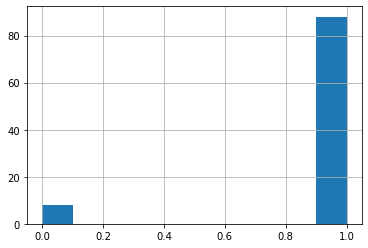

In [4]:
# histogram for label column shows that dataset is very imbalanced

echocardiogram_data["alive-at-1"].hist()
print("Distribution of classes in dataset:")
echocardiogram_data["alive-at-1"].value_counts()

In [5]:
# spliting data into train and test sets

from sklearn.model_selection import train_test_split

# split into X and y, drop irrelevant features: mult, name, group

echocardiogram_features=["age-at-heart-attack","pericardial-effusion","fractional-shortening","epss","lvdd","wall-motion-score","wall-motion-index"]
X=echocardiogram_data[echocardiogram_features]
y=echocardiogram_data["alive-at-1"]

# split data into train and test sets, using stratify because dataset is imbalanced

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Distribution of classes in training dataset:")
print(train_y.value_counts())
print()
print("Distribution of classes in test dataset:")
print(test_y.value_counts())

Distribution of classes in training dataset:
1    70
0     6
Name: alive-at-1, dtype: int64

Distribution of classes in test dataset:
1    18
0     2
Name: alive-at-1, dtype: int64


In [6]:
# preprocessing numerical data

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

def get_clf(scaler):
    if scaler is None:
        numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
    ])
    else:
        numerical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('scaler',scaler)
        ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, echocardiogram_features),
        ])

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', SVC())])
    
    return clf

In [7]:
# ROC AUC for test set

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score

def compute_roc_auc(model,test_X, test_y):
    test_y_scores = model.decision_function(test_X)

    fpr, tpr, thresholds = roc_curve(test_y, test_y_scores)

    print("ROC curve:")
    plt.plot(fpr, tpr, linewidth=2)
    plt.show()

    print("ROC AUC score: ", roc_auc_score(test_y, test_y_scores))

In [8]:
# confusion matrix

from sklearn.metrics import plot_confusion_matrix

def plt_confusion_matrix(model,test_X, test_y):
    print("Confusion matrix:")
    plot_confusion_matrix(model,test_X, test_y)  
    plt.show()

Scaler:  None
Model:
poly
ROC curve:


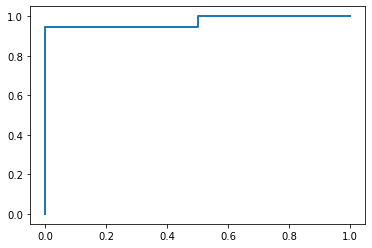

ROC AUC score:  0.9722222222222222
Confusion matrix:


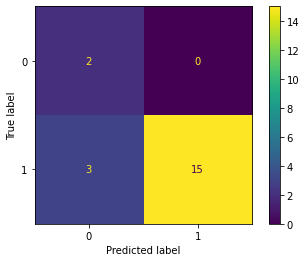

Scaler:  MinMaxScaler()
Model:
sigmoid
ROC curve:


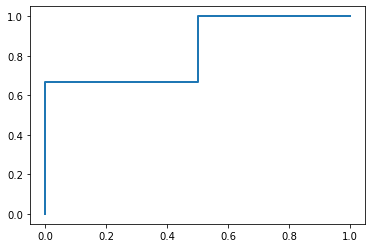

ROC AUC score:  0.8333333333333333
Confusion matrix:


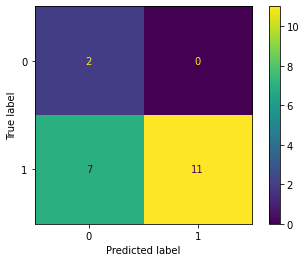

Scaler:  StandardScaler()
Model:
rbf
ROC curve:


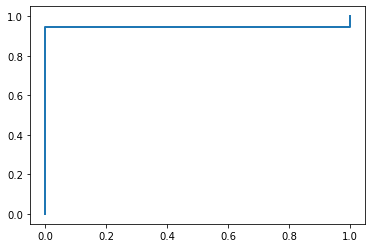

ROC AUC score:  0.9444444444444444
Confusion matrix:


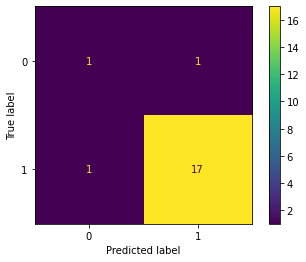

Scaler:  PCA(n_components=6)
Model:
rbf
ROC curve:


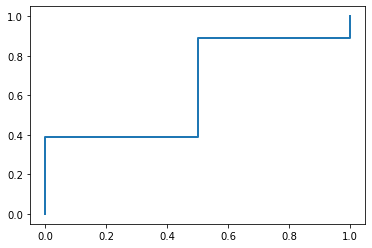

ROC AUC score:  0.6388888888888888
Confusion matrix:


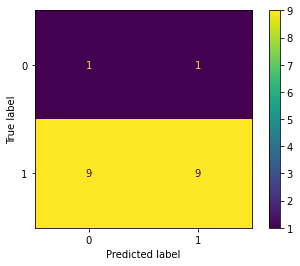

Scaler:  PCA(n_components=2)
Model:
rbf
ROC curve:


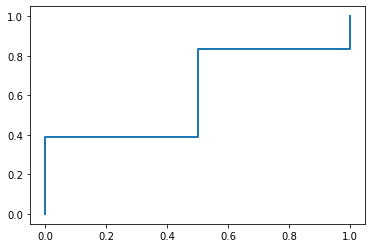

ROC AUC score:  0.6111111111111112
Confusion matrix:


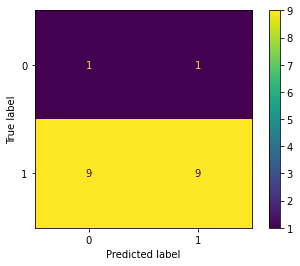

In [9]:
# grid search

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA

scalers_to_test = [None, MinMaxScaler(),StandardScaler(),PCA(n_components=6),PCA(n_components=2)]

for scaler in scalers_to_test:
    print('Scaler: ', str(scaler))
    
    param_grid = [{"classifier__kernel": ["linear", "poly", "rbf", "sigmoid"], 
         'classifier__C': [0.1,1, 10, 100, 1000], 'classifier__gamma': [0.1, 0.01, 0.001, 0.0001],
         "classifier__class_weight": ["balanced"],
        }]
    
    clf=get_clf(scaler)
    grid_search = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

    grid_search.fit(train_X, train_y)
    
    model = grid_search.best_estimator_
    
    print('Model:')
    print(model['classifier'])
    
    compute_roc_auc(model,test_X,test_y)
    
    plt_confusion_matrix(model,test_X,test_y)
    